# Notes - DS births recorded

In [48]:
import duckdb
import os
import numpy as np
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 1673025012
np.random.seed(RANDOM_SEED)

In [49]:
con = duckdb.connect("./data/us_births.db", read_only=True)

## Total records

There are 143 million records, including 68,515 live births with Down syndrome recorded. The status of Down syndrome is unknown in 23.6 million records (16.5%).

In [50]:
df = con.execute(
    """
    SELECT DISTINCT down_ind,
                    COUNT(*) as count_lb
    FROM us_births
    GROUP BY down_ind
    ORDER BY down_ind
    """
).df()
print(f"Total live births: {df['count_lb'].sum()}")
df

Total live births: 142865348


,down_ind,count_lb
0,0,119226426
1,1,68515
2,<NA>,23570407


## What does the flag `f_ca_downs` indicate?

2023 User Guide states "Reporting Flag for Down Syndrome: 0 = Non-Reporting, 1 = Reporting". However, the ratio of DS births recorded is higher in the 'Non-Reporting' group than in the ''Reporting' group. For group where `f_ca_downs` is not known (pre-2004), the ratio is similar to the 'Reporting' group.

We therefore disregard this flag in our analysis.

In [51]:
df = con.execute(
    """
    SELECT f_ca_downs,
           COUNT(*)                 as count_lb,
           SUM(down_ind)            as count_ds_rec,
           SUM(down_ind) / COUNT(*) as ratio_ds_rec
    FROM us_births
    WHERE down_ind IS NOT NULL
    GROUP BY f_ca_downs
    ORDER BY f_ca_downs
    """
).df()
df

,f_ca_downs,count_lb,count_ds_rec,ratio_ds_rec
0,0,809367,5977.0,0.007385
1,1,65174124,33760.0,0.000518
2,<NA>,53311450,28778.0,0.000540


### Unknowns

Many unknowns are seen in 2003 and for some years thereafter.

We treat 'Unknown' as 'Not recorded' in our analyses.

In [52]:
df = con.execute(
    """
    SELECT
        year, SUM (CASE WHEN down_ind IS NULL THEN 1 ELSE 0 END) AS count_NA, SUM (CASE WHEN down_ind = 0 THEN 1 ELSE 0 END) AS count_0, SUM (CASE WHEN down_ind = 1 THEN 1 ELSE 0 END) AS count_1
    FROM us_births
    GROUP BY year
    ORDER BY year;
    """
).df()
df

,year,count_NA,count_0,count_1
0,1989,710667.0,3333072.0,1954.0
1,1990,520905.0,3640029.0,1983.0
2,1991,497881.0,3615670.0,1791.0
3,1992,444096.0,3623516.0,1816.0
4,1993,261169.0,3741591.0,1763.0
5,1994,212623.0,3742596.0,1706.0
6,1995,277976.0,3623396.0,1640.0
7,1996,82599.0,3810598.0,1677.0
8,1997,85065.0,3797601.0,1663.0
9,1998,93706.0,3849804.0,1682.0


In [53]:
df = con.execute(
    """
    SELECT DISTINCT
        year, COALESCE (ca_down, ca_downs) as ds_indication, COUNT (*) as count, AVG (p_ds_lb_nt) as prob_ds_lb_nt, SUM (p_ds_lb_nt) as count_ds_lb_nt, SUM (down_ind) as count_down_ind,
    FROM
        us_births
    WHERE year >= 2004
    GROUP BY
        year, ds_indication
    ORDER BY
        year, ds_indication
    """
).df()
df

,year,ds_indication,count,prob_ds_lb_nt,count_ds_lb_nt,count_down_ind
0,2004,C,148,0.006387,0.945216,148.0
1,2004,N,751090,0.001817,1364.449813,0.0
2,2004,P,335,0.004731,1.584828,335.0
3,2004,U,7260,0.002237,16.238021,NaN
4,2004,None,3360074,0.001803,6057.174051,1465.0
...,...,...,...,...,...,...
91,2023,U,8333,0.002621,21.844448,NaN
92,2024,C,864,0.006910,5.970111,864.0
93,2024,N,3626913,0.002359,8557.542478,0.0
94,2024,P,1022,0.006655,6.801253,1022.0


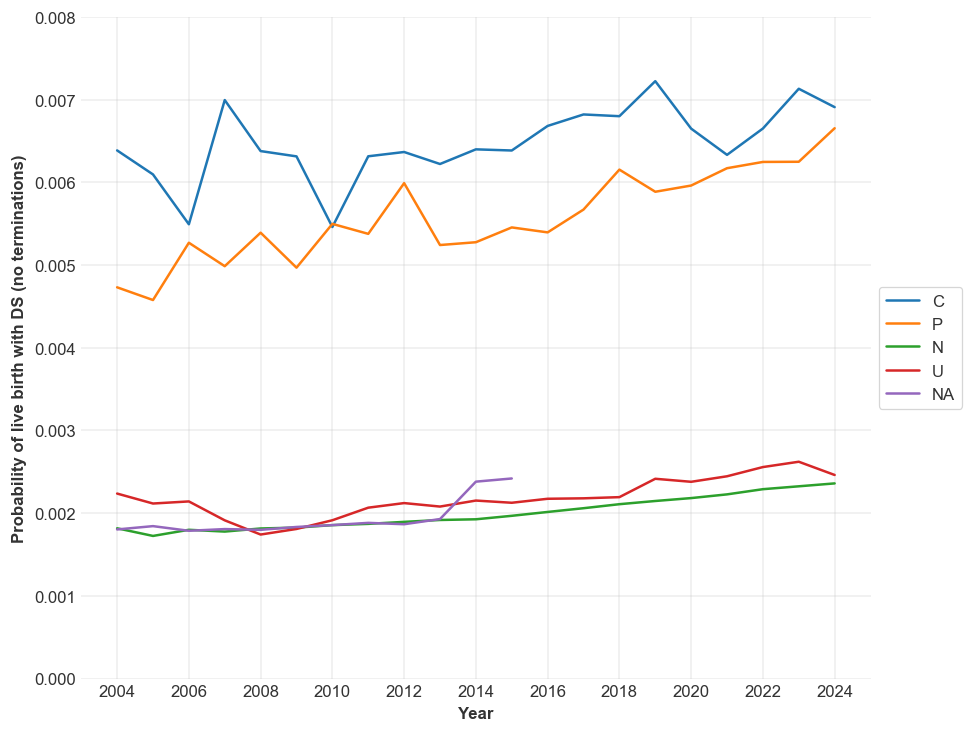

In [54]:
c_df = df[df["ds_indication"] == "C"]
p_df = df[df["ds_indication"] == "P"]
n_df = df[df["ds_indication"] == "N"]
u_df = df[df["ds_indication"] == "U"]
na_df = df[df["ds_indication"].isna()]
plt.plot(c_df["year"], c_df["prob_ds_lb_nt"], label="C")
plt.plot(p_df["year"], p_df["prob_ds_lb_nt"], label="P")
plt.plot(n_df["year"], n_df["prob_ds_lb_nt"], label="N")
plt.plot(u_df["year"], u_df["prob_ds_lb_nt"], label="U")
plt.plot(na_df["year"], na_df["prob_ds_lb_nt"], label="NA")
plt.xlim(2003, 2025)
plt.ylim(0, 0.008)
plt.xticks(np.arange(2004, 2025, 2))
plt.xlabel("Year")
plt.ylabel("Probability of live birth with DS (no terminations)")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

## Counts by year

In [55]:
df = con.execute(
    """
    SELECT DISTINCT
        year, COUNT (*) as count_lb, SUM (
        CASE
        WHEN COALESCE (ca_down, ca_downs) = 'C' THEN 1
        WHEN COALESCE (ca_down, ca_downs) = 'P' THEN 1
        ELSE 0
        END) as count_ds_indication, SUM (down_ind) as count_down_ind, SUM (p_ds_lb_nt) as count_ds_lb_nt, SUM (p_ds_lb_wt_mage) as count_ds_lb_wt_mage, SUM (p_ds_lb_wt_mage_reduc) as count_ds_lb_wt_mage_reduc, SUM (down_ind) / COUNT (*) as prob_ds_rec, SUM (down_ind) / SUM (p_ds_lb_nt) as ratio_nt_recorded, SUM (down_ind) / SUM (p_ds_lb_wt_mage) as ratio_wt_mage_recorded, SUM (down_ind) / SUM (p_ds_lb_wt_mage_reduc) as ratio_wt_mage_reduc_recorded,
    FROM
        us_births
    GROUP BY
        year
    ORDER BY
        year
    """
).df()
df

,year,count_lb,count_ds_indication,count_down_ind,count_ds_lb_nt,count_ds_lb_wt_mage,count_ds_lb_wt_mage_reduc,prob_ds_rec,ratio_nt_recorded,ratio_wt_mage_recorded,ratio_wt_mage_reduc_recorded
0,1989,4045693,0.0,1954.0,5435.804076,4199.990792,4201.805434,0.000483,0.359468,0.465239,0.465038
1,1990,4162917,0.0,1983.0,5716.629219,4391.978707,4394.402030,0.000476,0.346883,0.451505,0.451256
2,1991,4115342,0.0,1791.0,5794.837984,4431.747206,4433.762142,0.000435,0.309068,0.404130,0.403946
3,1992,4069428,0.0,1816.0,5888.002906,4406.742137,4408.741077,0.000446,0.308424,0.412096,0.411909
4,1993,4004523,0.0,1763.0,5957.920280,4376.743186,4378.555635,0.000440,0.295909,0.402811,0.402644
5,1994,3956925,0.0,1706.0,6063.337957,4360.634964,4361.998372,0.000431,0.281363,0.391227,0.391105
6,1995,3903012,0.0,1640.0,6140.807701,4374.942505,4376.564560,0.000420,0.267066,0.374862,0.374723
7,1996,3894874,0.0,1677.0,6279.330012,4280.770270,4281.998480,0.000431,0.267067,0.391752,0.391640
8,1997,3884329,0.0,1663.0,6396.586350,4365.918492,4367.179471,0.000428,0.259982,0.380905,0.380795
9,1998,3945192,0.0,1682.0,6598.625178,4482.158335,4483.180629,0.000426,0.254902,0.375266,0.375180


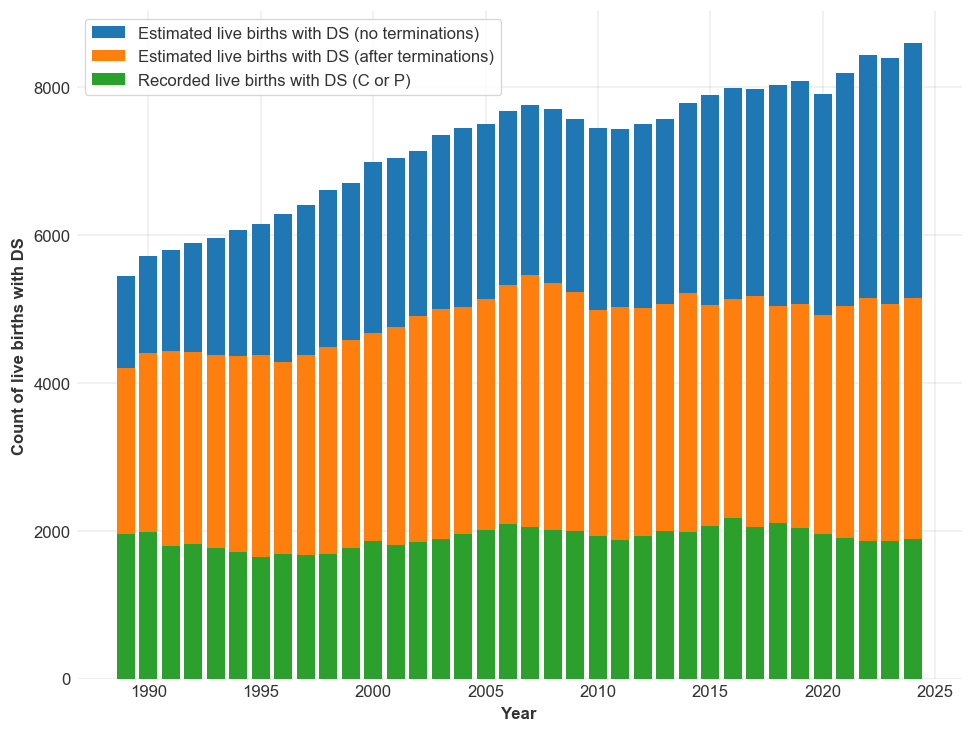

In [56]:
plt.bar(df["year"], df["count_ds_lb_nt"], label="Estimated live births with DS (no terminations)")
plt.bar(df["year"], df["count_ds_lb_wt_mage_reduc"], label="Estimated live births with DS (after terminations)")
plt.bar(df["year"], df["count_down_ind"], label="Recorded live births with DS (C or P)")
plt.xlabel("Year")
plt.ylabel("Count of live births with DS")
plt.legend()


## Proportion of estimated cases recorded

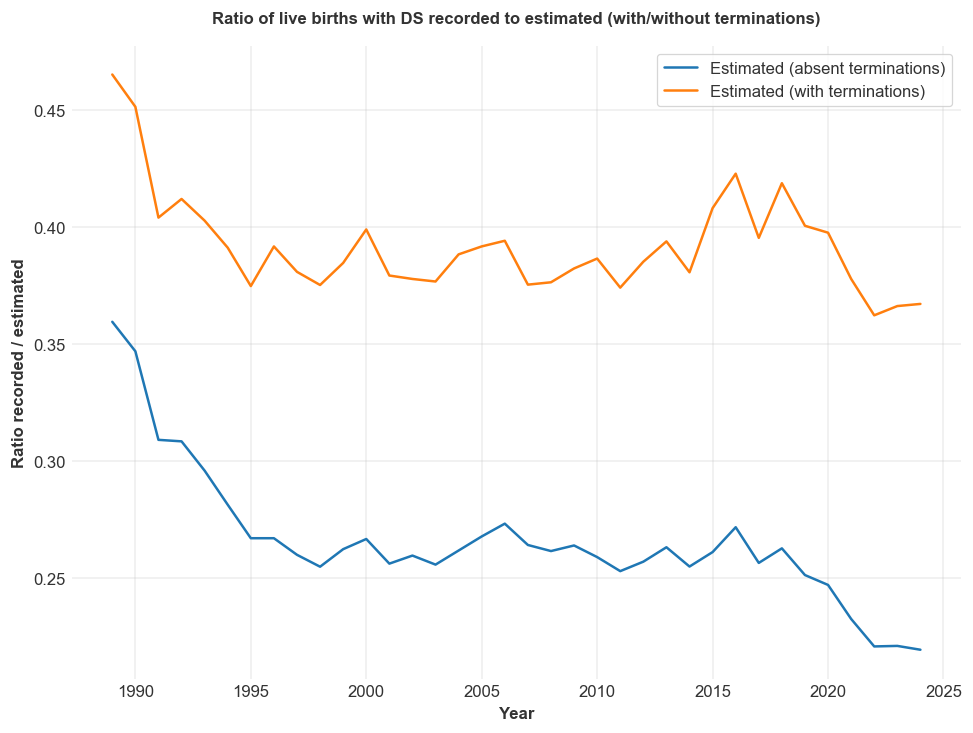

In [57]:
plt.plot(df["year"], df["ratio_nt_recorded"], label="Estimated (absent terminations)")
plt.plot(df["year"], df["ratio_wt_mage_reduc_recorded"], label="Estimated (with terminations)")
plt.xlabel("Year")
plt.ylabel("Ratio recorded / estimated")
plt.title("Ratio of live births with DS recorded to estimated (with/without terminations)", y=1.02)
plt.legend()

In [58]:
df = con.execute(
    """
    SELECT
        year, mrace15, count (*) as count
    FROM
        us_births
    WHERE year >= 2004
    GROUP BY
        year, mrace15
    ORDER BY
        year, mrace15
    """
).df()
df

,year,mrace15,count
0,2004,<NA>,4118907
1,2005,<NA>,4145614
2,2006,<NA>,4273225
3,2007,<NA>,4324008
4,2008,<NA>,4255156
...,...,...,...
172,2024,11,1231
173,2024,12,2009
174,2024,13,2303
175,2024,14,8834


In [59]:
df = con.execute(
    """
    SELECT
        year,
        CASE
            WHEN COALESCE (ca_down, ca_downs) = 'C' THEN 1
            WHEN COALESCE (ca_down, ca_downs) = 'P' THEN 1
            ELSE 0
        END
        as ca_down_c_or_p,
        COALESCE(f_ca_down, f_ca_downs) as f_ca_down_c,
        sex,
        mage_c,
        CASE
             WHEN dwgt_r >= 100 AND dwgt_r <= 400 THEN dwgt_r
             ELSE NULL
        END as dwgt_r,
        CASE
            WHEN bmi >= 13.0 AND bmi < 69.9 THEN bmi
            ELSE NULL
        END
        as bmi,
        CASE
            WHEN  meduc < 9 THEN meduc
            ELSE NULL
        END as meduc,
        CASE
            WHEN  feduc < 9 THEN feduc
            ELSE NULL
        END as feduc,
        CASE
            WHEN  mrace6 < 7 THEN mrace6
            ELSE NULL
        END as mrace6,
        CASE
            WHEN  frace6 < 7 THEN frace6
            ELSE NULL
        END as frace6,
        CASE
            WHEN  mhisp_r < 6 THEN mhisp_r
            ELSE NULL
        END as mhisp_r,
        CASE
            WHEN  fhisp_r < 6 THEN fhisp_r
            ELSE NULL
        END as fhisp_r,
        CASE
            WHEN  pay_rec < 5 THEN pay_rec
            ELSE NULL
        END as pay_rec
    FROM
        us_births
    WHERE year >= 2020
    ORDER BY
        year, dob_mm
    """
).df()
df

,year,ca_down_c_or_p,f_ca_down_c,sex,mage_c,dwgt_r,bmi,meduc,feduc,mrace6,frace6,mhisp_r,fhisp_r,pay_rec
0,2020,0,1,M,29,254,33.093750,4,4,1,1,0,0,2
1,2020,0,1,M,28,244,37.593750,6,7,2,2,0,0,1
2,2020,0,1,M,23,286,42.906250,3,3,1,1,0,0,1
3,2020,0,1,F,35,174,20.703125,7,7,1,1,0,0,3
4,2020,0,1,F,21,235,30.406250,3,3,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18209295,2024,0,1,M,23,179,25.500000,4,3,1,6,0,0,2
18209296,2024,0,1,F,22,171,27.796875,5,3,1,1,0,0,2
18209297,2024,0,1,F,19,154,21.093750,3,<NA>,1,<NA>,0,<NA>,1
18209298,2024,0,1,F,39,227,34.687500,6,5,1,1,0,0,2


In [60]:
df["sex"] = df["sex"].map({"M": 1, "F": 0}).astype("UInt8")
df["mage_c"] = df["mage_c"].astype("UInt16")
df["dwgt_r"] = df["dwgt_r"].astype("UInt8")
df["meduc"] = df["meduc"].astype("UInt8")
df["feduc"] = df["feduc"].astype("UInt8")
df["mrace6"] = df["mrace6"].astype("UInt8")
df.dtypes

year               uint16
ca_down_c_or_p      int32
f_ca_down_c         uint8
sex                 UInt8
mage_c             UInt16
dwgt_r              UInt8
bmi               float32
meduc               UInt8
feduc               UInt8
mrace6              UInt8
frace6              UInt8
mhisp_r             UInt8
fhisp_r             UInt8
pay_rec             UInt8
dtype: object

In [61]:
df.isna().mean().sort_values(ascending=False)

frace6            0.187012
feduc             0.134899
fhisp_r           0.124888
bmi               0.021539
meduc             0.016768
dwgt_r            0.011188
mhisp_r           0.009619
pay_rec           0.007922
mage_c            0.000000
ca_down_c_or_p    0.000000
year              0.000000
sex               0.000000
f_ca_down_c       0.000000
mrace6            0.000000
dtype: float64

In [62]:
df.columns

Index(['year', 'ca_down_c_or_p', 'f_ca_down_c', 'sex', 'mage_c', 'dwgt_r',
       'bmi', 'meduc', 'feduc', 'mrace6', 'frace6', 'mhisp_r', 'fhisp_r',
       'pay_rec'],
      dtype='object')

In [63]:
features = [
    "year", "f_ca_down_c", "pay_rec", "sex", "mage_c", "dwgt_r", "bmi", "meduc", "feduc", "mrace6", "frace6"
]
# , "mhisp_r", "fhisp_r"

X = df[features]
y = df["ca_down_c_or_p"].astype("int8")

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify=y
)

In [65]:
from lightgbm import early_stopping, log_evaluation

categorical = [ "f_ca_down_c", "pay_rec", "sex", "meduc", "feduc", "mrace6", "frace6" ]
numeric = ["year", "mage_c", "dwgt_r", "bmi",]

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical,
    free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False
)

# Rough imbalance handling
pos_rate = y_train.mean()
scale_pos_weight = (1 - pos_rate) / pos_rate  # negative/positive ratio

params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "metric": ["auc"],
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 5000,
    "max_bin": 255,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "min_gain_to_split": 0.0,
    "num_threads": 32,
    "scale_pos_weight": scale_pos_weight,
    "verbose": 1,
}

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=50)
    ]
)


[LightGBM] [Info] Number of positive: 8513, number of negative: 16379857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.192575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 16388370, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000519 -> initscore=-7.562213
[LightGBM] [Info] Start training from score -7.562213
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.574686	valid's auc: 0.567115
[100]	train's auc: 0.628523	valid's auc: 0.626823
Early stopping, best iteration is:
[1]	train's auc: 0.722368	valid's auc: 0.701474


In [66]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_valid_pred_proba = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

auc = roc_auc_score(y_valid, y_valid_pred_proba)
aupr = average_precision_score(y_valid, y_valid_pred_proba)

print(f"Validation AUC:  {auc:.4f}")
print(f"Validation AUPRC:{aupr:.4f}")


Validation AUC:  0.6726
Validation AUPRC:0.0010


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr_age = LogisticRegression(max_iter=1000)
lr_age.fit(X_train[["mage_c"]], y_train)
p_age = lr_age.predict_proba(X_valid[["mage_c"]])[:, 1]
print("AUC (age only):", roc_auc_score(y_valid, p_age))


AUC (age only): 0.6992520859254541


In [69]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame({
    "feature": features,
    "importance_gain": importance_gain
}).sort_values("importance_gain", ascending=False)

df_imp_gain


,feature,importance_gain
4,mage_c,1.854373e+09
6,bmi,6.493470e+07
5,dwgt_r,6.248556e+07
9,mrace6,2.445840e+07
10,frace6,4.231130e+06
0,year,0.000000e+00
1,f_ca_down_c,0.000000e+00
2,pay_rec,0.000000e+00
3,sex,0.000000e+00
8,feduc,0.000000e+00


In [ ]:
con.close()